In [ ]:
pip install factor-analyzer

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import os
import re
import sys
from scipy.sparse import csr_matrix
import warnings

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## scikit modeling libraries
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics.pairwise import sigmoid_kernel

#All the header files required for the code
import numpy as np
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
import random

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

#Preparing folder variables
os.chdir(os.path.dirname(sys.path[0])) # This command makes the notebook the main path and can work in cascade.
main_folder = sys.path[0]
data_folder = (main_folder + "\data")

# Hybrid Collaborative system with K-mean Clustering

In [8]:
anime = pd.read_csv(data_folder + "/" + "anime.csv")
rating = pd.read_csv(data_folder + "/" + "rating.csv.zip")

In [9]:
anime.head(2)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Military, Shounen",TV,64,9.26,793665


In [10]:
rating.head(2)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1


In [11]:
# Calculating each user average rating
userRatingDist = rating.groupby(['user_id']).mean().reset_index()
#userRatingDist.columns = ['user_id', 'average_rating_score']

In [12]:
URD1 = pd.merge(anime,rating,on=['anime_id','anime_id'])
URD2 = pd.merge(URD1,userRatingDist,on=['user_id','user_id'])
URD2= URD2[URD2.user_id <= 10000]

In [13]:
URD2 = URD2.drop(columns=["anime_id_y"])
URD2 = URD2.rename(columns = {"anime_id_x":"anime_id","rating_x":"overall_rating","rating_y":"user_rating","rating":"user_avg_rating"})

In [14]:
user_anime2 = pd.pivot_table(
    URD2,values="user_rating",
    index="user_id",
    columns="name"
)

In [15]:

user_anime3 = user_anime2.fillna(0)

In [16]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(user_anime3)
pca_samples = pca.transform(user_anime3)

In [17]:
user_gp = pd.DataFrame(pca_samples)
user_gp.head()

,0,1,2
0,-21.112792,-2.446000,1.230791
1,-18.533342,-3.024162,2.530621
2,4.884069,-14.540308,-14.954059
3,-20.909953,-2.604147,3.173222
4,28.486885,-8.663860,-1.749928


In [18]:
distortions = []
K = []
for i in range(2,10):
    model = KMeans(n_clusters=i)
    model.fit(user_gp)
    distortions.append(model.inertia_)
    K.append(i)

c:\Users\christiandda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\christiandda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\christiandda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\christiandda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

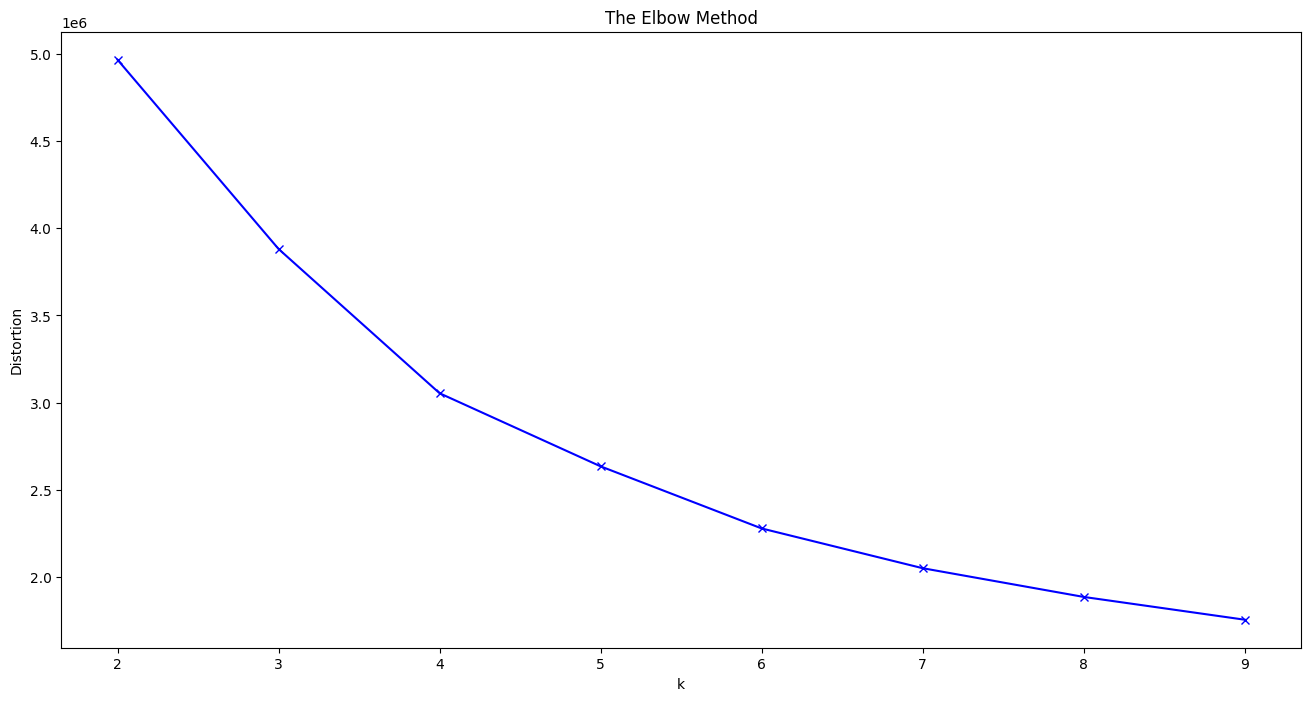

In [19]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

In [20]:
clstr = KMeans(n_clusters=6,random_state=0).fit(user_gp)
centroid = clstr.cluster_centers_
cntrd_preds = clstr.predict(user_gp)

print(centroid)

c:\Users\christiandda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[  0.92110719  14.16991511  -1.97429977]
 [ 12.36972887  -9.51460293  -6.52899532]
 [105.9508213    1.81689927  14.74447532]
 [-14.48544767  -1.76241812   1.40448964]
 [ 47.25937768 -24.74250153   2.75137969]
 [ 37.32216707  32.08577103   3.00379198]]


In [21]:

user_anime3['cluster']=cntrd_preds

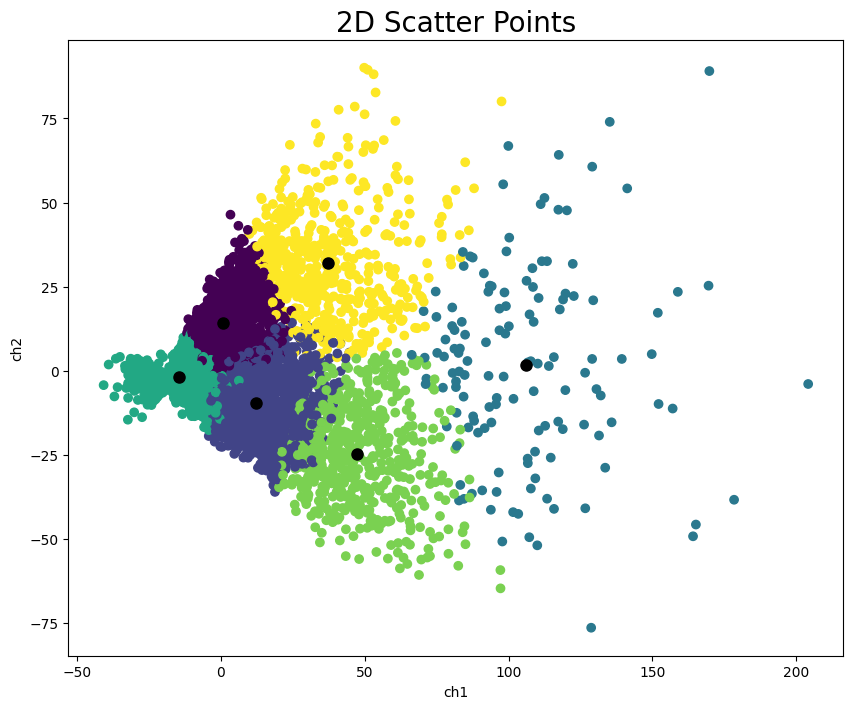

In [22]:
fig = plt.figure(figsize=(10,8))
plt.scatter(user_gp[0],user_gp[1],c = cntrd_preds)
for ci,c in enumerate(centroid):
    plt.plot(c[0], c[1], 'o', markersize=8, color='black', alpha=1)

plt.xlabel('ch1')
plt.ylabel('ch2')

plt.title('2D Scatter Points', fontsize=20)
plt.show()

In [23]:

c0 = user_anime3[user_anime3['cluster']==0].drop('cluster',axis=1).mean()
c1 = user_anime3[user_anime3['cluster']==1].drop('cluster',axis=1).mean()
c2 = user_anime3[user_anime3['cluster']==2].drop('cluster',axis=1).mean()
c3 = user_anime3[user_anime3['cluster']==3].drop('cluster',axis=1).mean()
c4 = user_anime3[user_anime3['cluster']==4].drop('cluster',axis=1).mean()
c5 = user_anime3[user_anime3['cluster']==5].drop('cluster',axis=1).mean()

In [24]:
df0 = pd.DataFrame(c0).reset_index().sort_values(by=[0], ascending = False)
df1 = pd.DataFrame(c1).reset_index().sort_values(by=[0], ascending = False)
df2 = pd.DataFrame(c2).reset_index().sort_values(by=[0], ascending = False)
df3 = pd.DataFrame(c3).reset_index().sort_values(by=[0], ascending = False)
df4 = pd.DataFrame(c4).reset_index().sort_values(by=[0], ascending = False)
df5 = pd.DataFrame(c5).reset_index().sort_values(by=[0], ascending = False)

In [25]:
df0 = df0.reset_index(drop=True).rename({0:"score"},axis = 1)
df1 = df1.reset_index(drop=True).rename({0:"score"},axis = 1)
df2 = df2.reset_index(drop=True).rename({0:"score"},axis = 1)
df3 = df3.reset_index(drop=True).rename({0:"score"},axis = 1)
df4 = df4.reset_index(drop=True).rename({0:"score"},axis = 1)
df5 = df5.reset_index(drop=True).rename({0:"score"},axis = 1)

In [26]:
def res(x):
    sc0 = df0.score[df0["name"] == x].tolist()
    sc1 = df1.score[df1["name"] == x].tolist()
    sc2 = df2.score[df2["name"] == x].tolist()
    sc3 = df3.score[df3["name"] == x].tolist()
    sc4 = df4.score[df4["name"] == x].tolist()
    sc5 = df5.score[df5["name"] == x].tolist()

    y = max(sc0, sc1, sc2, sc3, sc4, sc5)
    score=[sc0[0], sc1[0], sc2[0], sc3[0], sc4[0], sc5[0]]
    rcmd = {
        sc0[0]:df0,
        sc1[0]:df1,
        sc2[0]:df2,
        sc3[0]:df3,
        sc4[0]:df4,
        sc5[0]:df5
    }
    rcmd1 = {
        0:df0,
        1:df1,
        2:df2,
        3:df3,
        4:df4,
        5:df5
    }
    rcmd[y[0]]

    index = rcmd[y[0]].index[rcmd[y[0]]["name"] == x].tolist()

    list_name=[]
    index1=index[0]
    if index1 >=5 and index1<=(len(rcmd1[score.index(max(score))])-5):
        list_name.append(rcmd1[score.index(max(score))]['name'][(index1-5):index1])
        list_name.append(rcmd1[score.index(max(score))]['name'][index1+1:(index1+6)])
    elif index1 <5:
        list_name.append(rcmd1[score.index(max(score))]['name'][0:index1])
        list_name.append(rcmd1[score.index(max(score))]['name'][index1+1:11])
    else:
        list_name.append(rcmd1[score.index(max(score))]['name'][index1+1:len(rcmd1[score.index(max(score))])])
        list_name.append(rcmd1[score.index(max(score))]['name'][len(rcmd1[score.index(max(score))])-11: index1])

    rec_results = pd.DataFrame(list_name[0].tolist() + list_name[1].tolist(),columns = ["Recommended"])
    print(rec_results)

In [28]:
# test example: Kiseijuu: Sei no Kakuritsu
x = input()
res(x)

                         Recommended
0  Suzumiya Haruhi no Yuuutsu (2009)
1          Ichiban Ushiro no Daimaou
2                     Akame ga Kill!
3           Gekkan Shoujo Nozaki-kun
4          Higurashi no Naku Koro ni
5                        Golden Time
6                 Zetsuen no Tempest
7                             Ben-To
8                        Summer Wars
9                            Kannagi
